# Create a dataset of worldwide cities
This notebook processes several open-source GIS datasets containing relevant information on cities: 
* basic information such as population, geographical region, country, etc.
* population density data from the LandScan project
* nighttime luminosity data from NASA's VIIRS mission
* building density data from the GUF project
* city boundaries from the Census Bureau (US), Urban Atlas/Eurostat (EU), and GDAM (World)

The goal is to create a curated list of _major_ cities world-wide to use in subsequent analysis and machine learning applications.

The approach we follow is:
* start from the GADM database of administrative boundaries for world cities. This data contains city, province, and country names/codes, as well as geometry (polygon) data of boundaries for about $46,000$ cities'
* use the LandScan data to extract the population for each city. This will give consistent (if perhaps inaccurate) estimates for population.
* retain just major cities (over 10,000 inhabitants) for analysis

Another route could have been to start with a list of cities and their population (e.g., the one available at [this link](https://www.maxmind.com/en/free-world-cities-database)). However, there are issues (mainly slight differences in city names, e.g., different spellings, accents, dashes, etc.) in integrating cities in that list with information from other databases, particularly the administrative boundaries. 

### Load packages

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
from shapely.ops import cascaded_union

import sys, os, time
import glob
import copy

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# path to save data

outPath = "./home/data/world-cities/"

if not os.path.exists(outPath):
	os.makedirs(outPath)

# Integrate GIS raster datasets

In [3]:
# satellite imagery modules
import pysatml
from pysatml import satimage as satimg

In [4]:
# client for SAR built geometry -> GUF data

bld_sarguf_path = "C:/Users/bramv/Downloads/Lay-out 1.tif"
sarFiles = glob.glob(bld_sarguf_path)
sarImgClient = satimg.SatImage(sarFiles)

(-38.61885176072606, 0.003387946763673903, 0.0, 89.82203687196417, 0.0, -0.0033878957124800985)


In [5]:
# client for nightlights

luminosity_path = 'C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master/urbanization-patterns-master/data/nasa/big/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.lit_mask.tif'
nliFiles = glob.glob(luminosity_path)
nliImgClient = satimg.SatImage(nliFiles)

(-180.00208333335, 0.0041666667, 0.0, 75.00208333335, 0.0, -0.0041666667)


In [6]:
# client for population density

population_path = "C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master/urbanization-patterns-master/data/landscan-global-2022-assets/landscan-global-2022.tif"
popFiles = glob.glob(population_path)
popImgClient = satimg.SatImage(popFiles)

(-180.0, 0.0083333333333333, 0.0, 89.99999999999929, 0.0, -0.0083333333333333)


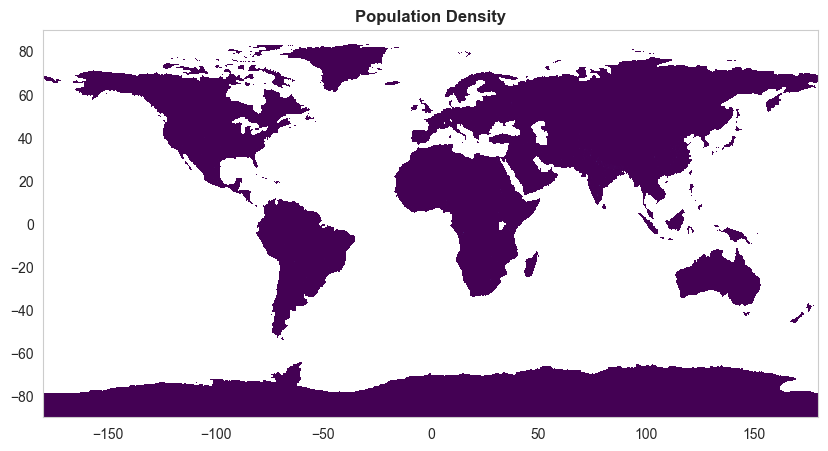

In [7]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
# Open the GeoTIFF file
with rasterio.open(population_path) as src:
    # Read the population data
    population_data = src.read(1)

    # Plot the population data
    plt.figure(figsize=(10, 10))
    show(src, cmap='viridis', title='Population Density')
    plt.show()

# Process administrative boundary data

Boundaries for whole world are available from the [GADM database](http://www.gadm.org/version2).

In [40]:
boundaries_path = "C:/Users/bramv/Downloads/gadm_410-gpkg/gadm_410.gpkg"

gadm_gdf = gpd.read_file(boundaries_path)
gadm_gdf.dropna(subset=['TYPE_2', 'NAME_2'], inplace=True)


gadm_gdf = gadm_gdf[gadm_gdf['CONTINENT'] == 'Europe']

print(gadm_gdf.shape)

gadm_gdf.head()

(106252, 53)


,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,HASC_1,...,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,geometry
332,333,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.98333 60.64167, 20.98125 60..."
333,334,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.60028 59.81311, 20.60027 59..."
334,335,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.83333 60.03333, 20.83301 60..."
335,336,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.76042 60.46667, 20.75833 60..."
336,337,ALA,Åland,,ALA.1_2,Archipelago,Archipelago,,,AX.AR,...,,,Finland,,,,Åland,Europe,,"MULTIPOLYGON (((20.56875 60.18333, 20.56667 60..."


In [69]:
# output_file = "C:/Users/bramv/Downloads/Paris_gdf.gpkg"

# # Export the GeoDataFrame to a GeoPackage file
# gadm_gdf.to_file(output_file, driver='GPKG')

# print(f"Exported to {output_file}")

Exported to C:/Users/bramv/Downloads/Paris_gdf.gpkg


In [33]:
# gadm_gdf.dropna(subset=['TYPE_2', 'NAME_2'], inplace=True)

In [38]:
# # load gadm_gdf
# output_file = "C:/Users/bramv/Downloads/gadm_gdf.gpkg"

# gadm_gdf = gpd.read_file(output_file)

In [46]:
athens = gadm_gdf[gadm_gdf['NAME_1'] == 'Bucharest']
europe = gadm_gdf

athens.head()

,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,HASC_1,...,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,geometry
270093,270094,ROU,Romania,,ROU.10_1,Bucharest,Bucuresti,,,RO.BI,...,,,Romania,,,,Romania,Europe,,"MULTIPOLYGON (((26.16712 44.34348, 26.15573 44..."


#### Create processed dataset of cities and their boundaries

In [47]:

gadm_gdf = athens
gadm_gdf

,UID,GID_0,NAME_0,VARNAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,ISO_1,HASC_1,...,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION,COUNTRY,CONTINENT,SUBCONT,geometry
270093,270094,ROU,Romania,,ROU.10_1,Bucharest,Bucuresti,,,RO.BI,...,,,Romania,,,,Romania,Europe,,"MULTIPOLYGON (((26.16712 44.34348, 26.15573 44..."


In [48]:
# some country/city names contain non-ASCII characters encoded as UTF-8

utf8_to_ascii = lambda x: u''.join([x]).encode('utf-8').strip().decode("utf-8").encode("ascii", "ignore")

import re
clean_string = lambda s: re.sub(r'[^a-zA-Z0-9 ]','', s).strip()

# utility functions to compute sizes of polygons in km
from pysatml.utils.gis_utils import \
    compute_geo_distance_km, compute_polygon_area_km2, compute_polygon_size


In [55]:
cities_gdf = gadm_gdf[['NAME_0', 'GID_0', 'NAME_1', 'NAME_2', 'geometry']].copy()
cities_gdf.rename(columns={"NAME_1":"province", 
                           "GID_0":"countrycode",
                           "NAME_2":"city",
                           'NAME_0':"country"}, inplace=True)


# some cities/municipalities have the same name/province/country,
# we assume that they're part of the same region, and combine the boundary
# into a single polygon
cities_gdf = cities_gdf.groupby(['city', 'province', 'country', 'countrycode'])\
    .apply(lambda x: cascaded_union(x['geometry'].values) if len(x)>1 else x['geometry'].values[0]).reset_index()\
    .rename(columns={0:"geometry"})
cities_gdf = gpd.GeoDataFrame(cities_gdf) # the groupby operation casts to a Pandas DataFrame


In [56]:
cities_gdf

,city,province,country,countrycode,geometry
0,Municipiul Bucuresti,Bucharest,Romania,ROU,"MULTIPOLYGON (((26.16712 44.34348, 26.15573 44..."


In [51]:
from pyproj import Geod
wgs84_geod = Geod(ellps="WGS84")

def compute_geo_distance_km(latlon1, latlon2, transformer):
    lon1, lat1 = latlon1
    lon2, lat2 = latlon2

    if transformer is not None:
        lon1, lat1 = transformer.transform(lon1, lat1)
        lon2, lat2 = transformer.transform(lon2, lat2)

    az12, az21, dist = wgs84_geod.inv(lon1, lat1, lon2, lat2)

    return dist / 1.0e3  # return km

def compute_polygon_size(p, transformer):
    bbox = p.bounds

    try:
        # Corrected ordering of coordinates when calling compute_geo_distance_km
        L = compute_geo_distance_km((bbox[1], bbox[0]), (bbox[1], bbox[2]), transformer)
        W = compute_geo_distance_km((bbox[1], bbox[0]), (bbox[3], bbox[0]), transformer)
    except Exception as e:
        print("Error computing distances:", e)
        L, W = np.nan, np.nan

    # Check if L and W are NaN, and if so, return NaN for 'scale'
    if np.isnan(L) or np.isnan(W):
        return np.nan
    
    # Compute the maximum and minimum of the calculated dimensions
    scale = max([L, W]), min([L, W])
    return scale


In [52]:
# Set the CRS for the GeoDataFrame
original_crs = 'EPSG:4326'
target_crs = {'proj': 'aea', 'lat_1': 0, 'lat_2': 20}

cities_gdf.crs = original_crs
cities_gdf = cities_gdf.to_crs(target_crs)

# Apply the function to calculate 'scale' for each polygon
cities_gdf['scale'] = cities_gdf.apply(lambda row: compute_polygon_size(row['geometry'], target_crs), axis=1)

# individual columns for length and width
# cities_gdf[['length', 'width']] = pd.DataFrame(cities_gdf['scale'].tolist(), index=cities_gdf.index)

# If you also want to add the centroid as 'location' column
cities_gdf['location'] = cities_gdf['geometry'].centroid

# Calculate the area in the new CRS
cities_gdf['area'] = cities_gdf['geometry'].area / 1.0e6

Error computing distances: 'dict' object has no attribute 'transform'


In [57]:
import numpy as np
import geopandas as gpd
import pandas as pd
from pyproj import CRS, Transformer, Geod

# Assuming you have already imported the necessary libraries and have the GeoDataFrame 'cities_gdf'

# Define the WGS84 geodetic reference system
wgs84_crs = CRS("EPSG:4326")

def compute_geo_distance_km(latlon1, latlon2):
    lat1, lon1 = latlon1
    lat2, lon2 = latlon2

    az12, az21, dist = wgs84_geod.inv(lon1, lat1, lon2, lat2)

    return dist / 1.0e3  # return km

def compute_polygon_size(p):
    bbox = p.bounds

    try:
        L = compute_geo_distance_km((bbox[1], bbox[0]), (bbox[3], bbox[0]))
        W = compute_geo_distance_km((bbox[1], bbox[0]), (bbox[1], bbox[2]))
    except Exception as e:
        print("Error computing distances:", e)
        L, W = np.nan, np.nan

    # Compute the maximum of the calculated dimensions
    max_dimension = max([L, W])
    return max_dimension


# Set the CRS for the GeoDataFrame
original_crs = 'EPSG:4326'

transformer = Transformer.from_crs(original_crs, original_crs, always_xy=True)
wgs84_geod = Geod(ellps="WGS84")

cities_gdf.crs = original_crs

cities_gdf['scale'] = cities_gdf['geometry'].apply(compute_polygon_size)

# If you want to add individual columns for length and width
# cities_gdf[['length', 'width']] = pd.DataFrame(cities_gdf['scale'].tolist(), index=cities_gdf.index)

# If you also want to add the centroid as 'location' column
cities_gdf['location'] = cities_gdf['geometry'].centroid

# Calculate the area in the original CRS (EPSG:4326) and convert to square kilometers
cities_gdf['area'] = cities_gdf['geometry'].to_crs({'proj': 'cea'}).area / 1.0e6


# Display or use the updated GeoDataFrame
# print(cities_gdf[['city', 'province', 'country', 'area', 'scale', 'population', 'length', 'width', 'location']])


In [58]:
cities_gdf.head()

,city,province,country,countrycode,geometry,scale,location,area
0,Municipiul Bucuresti,Bucharest,Romania,ROU,"MULTIPOLYGON (((26.16712 44.34348, 26.15573 44...",23.077966,POINT (26.08861 44.44267),241.332272


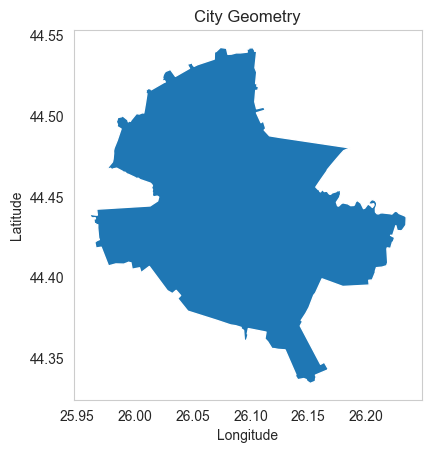

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and has a 'geometry' column
gdf = gpd.GeoDataFrame(cities_gdf, geometry='geometry')

# Plot the geometry
gdf.plot()
plt.title("City Geometry")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
path = 'C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master/urbanization-patterns-master/data/'
gdf["geometry"].to_file(path + "world-cities/Bucharest/Bucharest_bnd.shp")

In [64]:
gdf

,city,province,country,countrycode,geometry,scale,location,area
0,Municipiul Bucuresti,Bucharest,Romania,ROU,"MULTIPOLYGON (((26.16712 44.34348, 26.15573 44...",23.077966,POINT (26.08861 44.44267),241.332272


ValueError: Source shape (1, 793, 768, 3) is inconsistent with given indexes 1

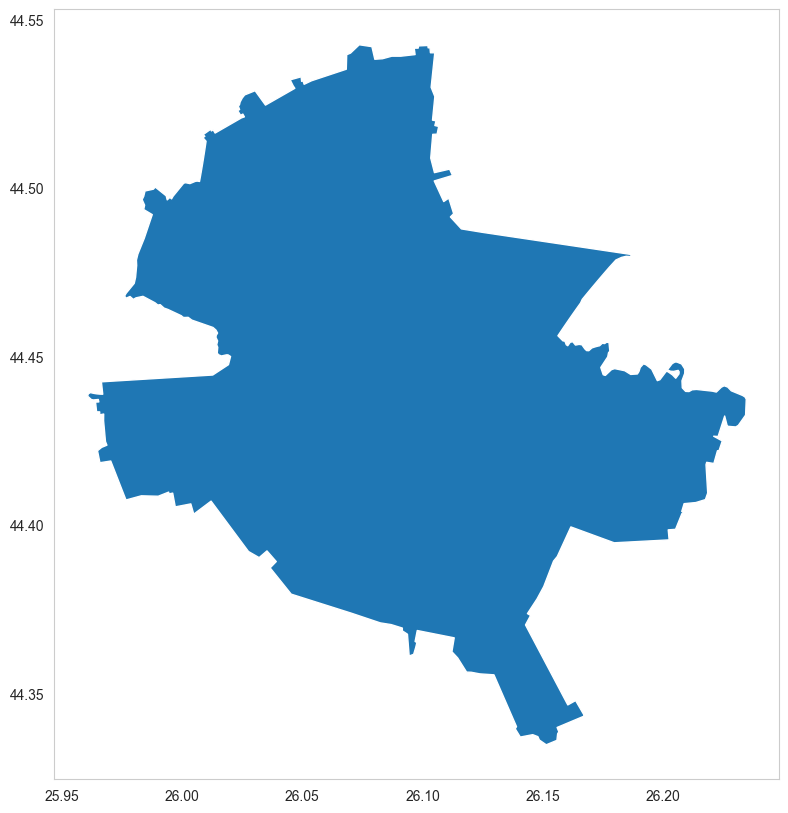

In [62]:
from rasterio.transform import from_origin
from rasterio.enums import Resampling


fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometry
gdf.plot(ax=ax)

# Save the figure as a GeoTIFF file
output_tiff_path = "C:/Users/bramv/OneDrive - Square Four/Documenten/Leiden/23-24/urban computing/urbanization-patterns-master/urbanization-patterns-master/data/world-cities/Bucharest/Bucharest_BND.tif"

xmin, ymin, xmax, ymax = ax.axis()

# Set up a transformation from the bounding box
transform = from_origin(xmin, ymax, abs(xmax - xmin) / 500, abs(ymax - ymin) / 500)

# Save the plot as an image
plt.savefig('temp_plot.png', format='png', bbox_inches='tight', pad_inches=0)

# Read the image with matplotlib
img = plt.imread('temp_plot.png')

# Remove the temporary image file
import os
os.remove('temp_plot.png')

# Create a rasterio dataset and write the plot to it
with rasterio.open(
    output_tiff_path,
    'w',
    driver='GTiff',
    height=img.shape[0],
    width=img.shape[1],
    count=3,  # RGB bands
    dtype='uint8',
    crs='EPSG:4326',
    transform=transform
) as dst:
    # Write the plot to the rasterio dataset
    dst.write(img[:, :, :3] * 255, 1)  # Save only RGB bands

# Show the plot
plt.show()

#### Estimate population within city boundary for each city

In [29]:
thresh_pop = 50  # int(1.5 * 100 * 9.0/16)

city_population = []

for j, (i, r) in enumerate(cities_gdf.iterrows()):
    lonlat, boundary = r['location'].centroid.xy, r['geometry']
    cityname, countrycode = r['city'], r['countrycode']
    lon, lat = lonlat[0][0], lonlat[1][0]

    try:
        imgPOP = popImgClient.extract_polygon_mask(boundary, w=200)
    except TypeError:
        # Handle MultiPolygon
        imgPOP = popImgClient.extract_polygon_mask(max(boundary.geoms, key=lambda x: x.area), w=200)

    imgPOP, bounds_mask = imgPOP[0], imgPOP[1]
    imgPOP[imgPOP < thresh_pop] = 0
    city_pop = imgPOP[bounds_mask > 0].sum()
    city_population.append(city_pop)

    clear_output(wait=True)
    print("%s, %s (%d/%d): %d pop" % (cityname, countrycode, j, len(cities_gdf), city_pop))

city_population = pd.Series(city_population)
cities_gdf['population'] = city_population


AttributeError: 'NoneType' object has no attribute 'shape'

In [77]:
# set paris population to 2.2 million
cities_gdf.loc[cities_gdf['city'] == 'Paris', 'population'] = 2200000

cities_gdf.head()

,city,province,country,countrycode,geometry,scale,location,area,population
0,Paris,Île-de-France,France,FRA,"POLYGON ((2.27193 48.82888, 2.26762 48.83420, ...","(26.87388021996514, 9.554692017763216)",POINT (2.34233 48.85664),104.923119,2200000.0


In [78]:
# classify cities by population scale
# adapted after the new classification of Chinese cities
# http://english.gov.cn/policies/latest_releases/2014/11/25/content_281475015213546.htm

def f_classify_by_pop(d):
    if d < 100000:
        return "very-small"
    elif d < 200000:
        return "small-1"
    elif d < 500000:
        return "small-2"
    elif d < 1e6:
        return "medium"
    elif d < 5e6:
        return "large"
    else:
        return "very-large"

cities_gdf['size'] = cities_gdf["population"].apply(f_classify_by_pop)

In [94]:
cities_gdf.head()

,city,province,country,countrycode,geometry,scale,location,area,population,size
0,Paris,Île-de-France,France,FRA,"POLYGON ((2.27193 48.82888, 2.26762 48.83420, ...",17.848805,POINT (2.34233 48.85664),104.923119,2200000.0,large


#### Save data to csv/shapefiles

In [81]:
cities_gdf['location'] = cities_gdf['location'].apply(lambda point: point.wkt if point else None)


In [95]:
# Save data on all cities
cities_gdf.to_csv(outPath + "all_cities.csv")
cities_gdf.drop(columns='location').to_file(driver='ESRI Shapefile', filename=outPath + "boundaries/all_cities.shp")

# Save a subset of cities over 10k population
cities_gdf[cities_gdf['population']>10000].to_csv(outPath + "cities_over_10kpop.csv")
cities_gdf.drop(columns='location').to_file(driver='ESRI Shapefile', filename=outPath + "boundaries/cities_over_10kpop.shp")


In [37]:
cities_gdf = gpd.read_file(outPath + "boundaries/all_cities.shp")

# Basic validation analysis

In [96]:
print(cities_gdf['scale'].unique())
print("NaN count:", cities_gdf['scale'].isna().sum())


[17.8488052]
NaN count: 0


#GADMs with scale>200km: 0 / 1


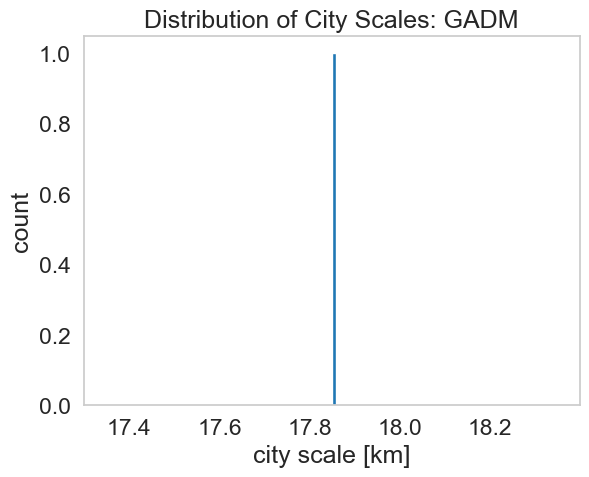

In [97]:
print ("#GADMs with scale>200km: %d / %d" % (len(cities_gdf['scale'][cities_gdf['scale']>200]), len(cities_gdf['scale'])))

sns.set_context("notebook", font_scale=1.5, rc={'axes.grid' : False})
cities_gdf['scale'][cities_gdf['scale']<200].hist(bins=100)
plt.xlabel("city scale [km]")
plt.ylabel("count")
plt.title("Distribution of City Scales: GADM")
plt.grid(False)

In [98]:
g = sns.FacetGrid(cities_gdf[cities_gdf['scale']<200], col="region", hue="region")
g = g.map(plt.hist, "scale", log=False, bins=100)
g.fig.suptitle("Distribution of city scale across regions\n\n")

KeyError: 'region'

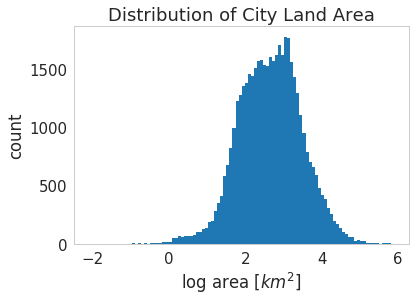

In [8]:
sns.set_context("notebook", font_scale=1.5, rc={'axes.grid' : False})

cities_gdf['area'].apply(np.log10).hist(bins=100)
plt.xlabel("log area [$km^2$]")
plt.ylabel("count")
plt.title("Distribution of City Land Area")
plt.grid(False)

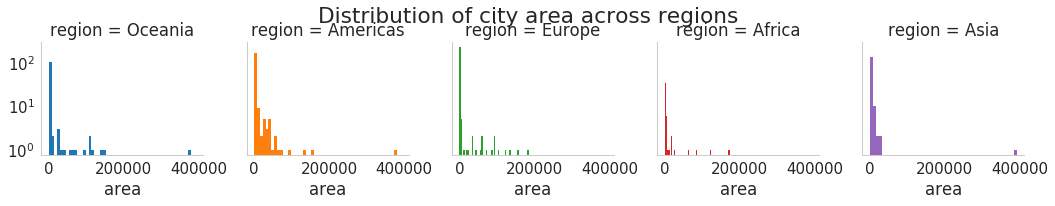

In [9]:
g = sns.FacetGrid(cities_gdf[cities_gdf['population']<500], col="region", hue="region")
g = g.map(plt.hist, "area", log=True, bins=50)
g.fig.suptitle("Distribution of city area across regions\n\n")

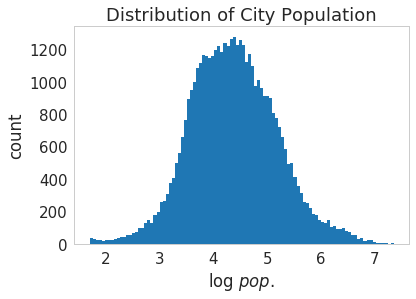

In [10]:
pd.Series(cities_gdf['population']).apply(np.log10).hist(bins=100)
plt.xlabel("log $pop.$")
plt.ylabel("count")
plt.title("Distribution of City Population")
plt.grid(False)

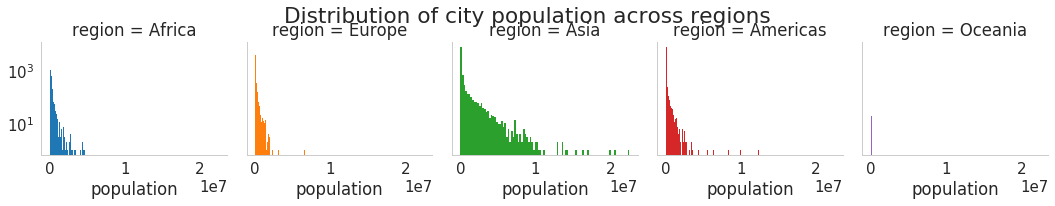

In [11]:
g = sns.FacetGrid(cities_gdf[cities_gdf['population']>10000], col="region", hue="region")
g = g.map(plt.hist, "population", log=True, bins=100)
g.fig.suptitle("Distribution of city population across regions\n\n")

#### City scaling plots: log P(A) vs A, with A the area/population

In [12]:
from scipy import stats

def compute_loglog_fit(cur_var):
    q1, q99 = np.percentile(cur_var, [1,99])
    bins = np.logspace(np.log10(q1), np.log10(q99), 20, base=10)
    N_counts, var = np.histogram(cur_var, bins=bins)
    prob_bins= N_counts / float(N_counts.sum()) + 1e-4
    a, b, R, p, s = stats.linregress(np.log10(bins[:-1]), np.log10(prob_bins))
    prob_fit = b + a * np.log10(bins)
    prob_fit = np.power(10, prob_fit)
    return (bins, prob_bins), (prob_fit, a*np.log(10), p, s)

In [13]:
mycountries = ['united states', 'united kingdom', 
               'china', 'brazil', 'india', 'russia', 'south africa']

for c in mycountries:
    print "%20s: %d cities." % (c, (cities_gdf.country.str.contains(c)).sum())

       united states: 3143 cities.
      united kingdom: 192 cities.
               china: 340 cities.
              brazil: 5488 cities.
               india: 666 cities.
              russia: 2278 cities.
        south africa: 52 cities.


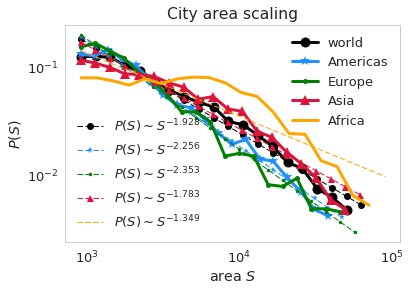

In [42]:
t = 900
field = 'area'
# region='country' 
region='region' 

# whole world
cur_pop  = cities_gdf[field].values
cur_var = cur_pop[cur_pop>t].copy()
(bins, prob_bins), (prob_fit, a, p, s) = compute_loglog_fit(cur_var)

d, = plt.loglog(bins[:-1], prob_bins, lw=3, markersize=10, label='world', color='k', marker='o')
f, = plt.loglog(bins, prob_fit, label="$P(S)\sim S^{%2.3f}$"%(a), lw=1, linestyle="--", color='k', marker='o')

# mycountries_sel = ['united states', 'brazil', 'russia']
mycountries_sel = ['Americas', 'Europe', 'Asia', 'Africa']
# mycountries_sel = ['united kingdom', 'china', 'india']
colors = ["dodgerblue", "green", "crimson", "orange"]
markers= ["*", '.', '^', '+']

sns.set_context("notebook", font_scale=1.3)

data_legend = [d]
fits_legend = [f]
for c,color,marker in zip(mycountries_sel, colors, markers):
    cur_gdf  = cities_gdf[cities_gdf[region]==c]
    cur_pop  = cur_gdf[field].values

    cur_var = cur_pop[cur_pop>t].copy()

    (bins, prob_bins), (prob_fit, a, p, s) = compute_loglog_fit(cur_var)

    d, = plt.loglog(bins[:-1], prob_bins, marker=marker, lw=3, markersize=10, label=c, color=color)
    plt.xlabel("%s $S$" % field)
    plt.ylabel("$P(S)$")
    data_legend += [d]
    f, = plt.loglog(bins, prob_fit, label="$P(S)\sim S^{%2.3f}$"%(a), lw=1, linestyle="--", color=color, marker=marker)
    fits_legend += [f]
    
data_legend = plt.legend(handles=data_legend, loc=1) #bbox_to_anchor=(1.52, 0.55))
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(data_legend)

# Create another legend for the second line.
plt.legend(handles=fits_legend, loc=3)# bbox_to_anchor=(1.48, 1.05))

# plt.legend(loc="best", ncol=2)
plt.title("City %s scaling" % field)

#### Plot scaling relations across regions/subregions

In [15]:
from matplotlib import colors as mcolors
all_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

from six import iteritems
from matplotlib.lines import Line2D
unfilled_markers = [m for m, func in iteritems(Line2D.markers)
                    if func != 'nothing' and m not in Line2D.filled_markers]


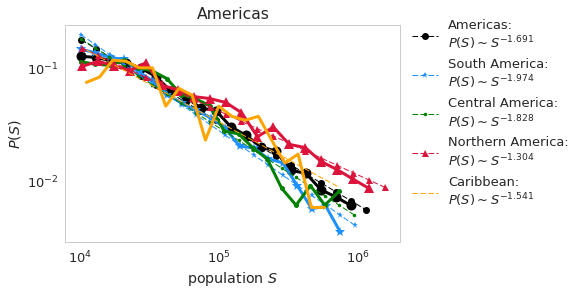

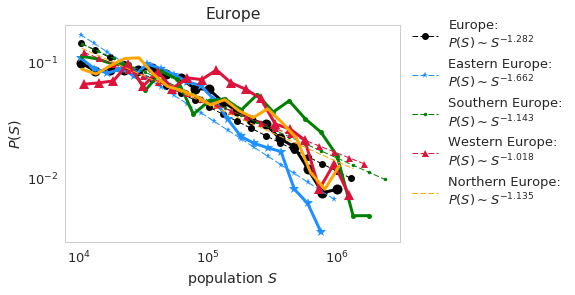

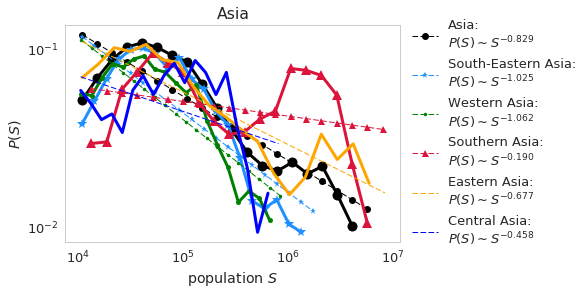

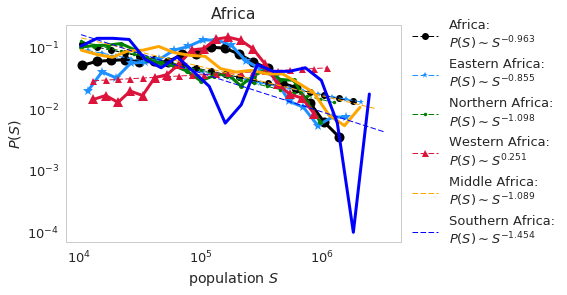

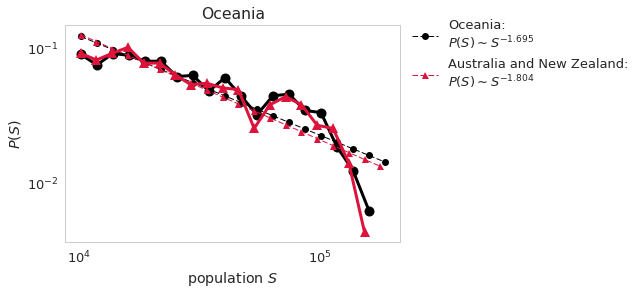

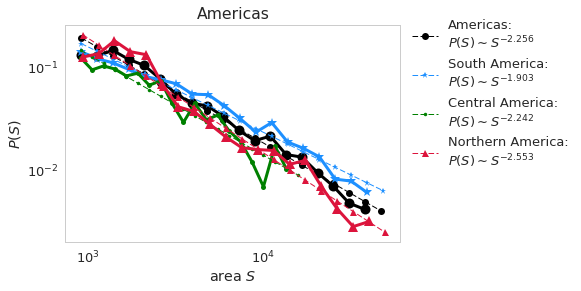

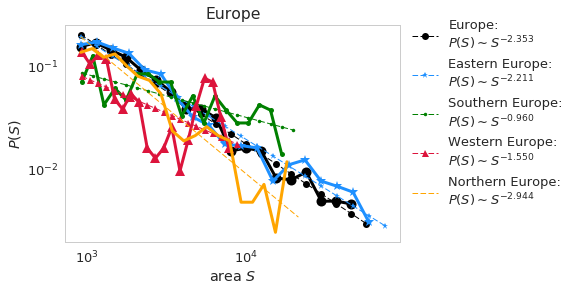

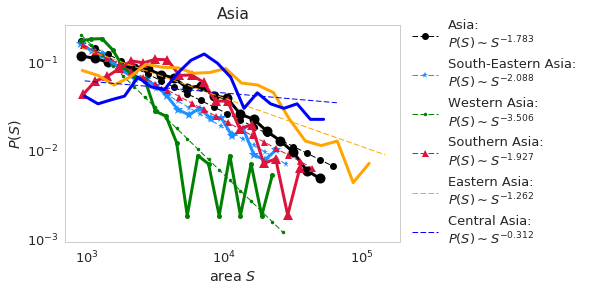

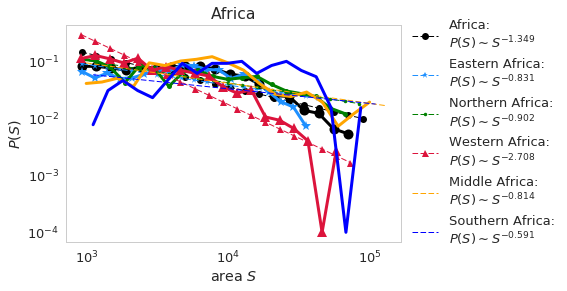

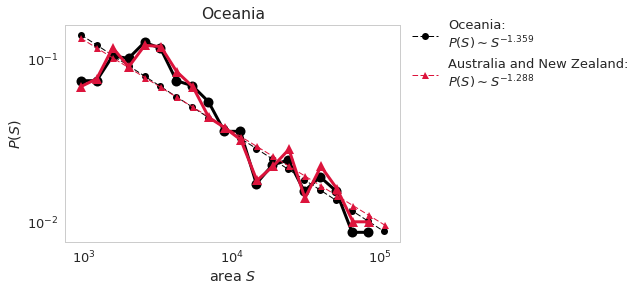

In [44]:

regions = ['Americas', 'Europe', 'Asia', 'Africa', 'Oceania']
colors = ["dodgerblue", "green", "crimson", "orange", "blue"]
markers= ["*", '.', '^', '|', 'x', '4']

sns.set_context("notebook", font_scale=1.3)
for field,t  in zip(['population', 'area'], [10000, 900]):
    for region in regions:
        fig, ax = plt.subplots(1,1,figsize=(6,4))

        cur_gdf  = cities_gdf[(cities_gdf.region==region)]
        cur_pop  = cur_gdf[field].values
        cur_var = cur_pop[cur_pop>t].copy()

        (bins, prob_bins), (prob_fit, a, p, s) = compute_loglog_fit(cur_var)
        d, = ax.loglog(bins[:-1], prob_bins, marker='o', lw=3, markersize=10, label=region, color='k')
        f, = ax.loglog(bins, prob_fit, label="%s:\n$P(S)\sim S^{%2.3f}$"%(region,a), lw=1, linestyle="--", color='k', marker='o')

        mylegend = [f]
        subregions = cities_gdf[cities_gdf.region==region].subregion.unique()
        for subreg,color,marker in zip(subregions, colors, markers):
            cur_gdf  = cities_gdf[(cities_gdf.region==region) & (cities_gdf.subregion==subreg)]
            cur_pop  = cur_gdf[field].values
            cur_var = cur_pop[cur_pop>t].copy()
            if len(cur_var)<100:
                continue
            (bins, prob_bins), (prob_fit, a, p, s) = compute_loglog_fit(cur_var)
            d, = ax.loglog(bins[:-1], prob_bins, marker=marker, lw=3, markersize=10, label=subreg, color=color)
            f, = ax.loglog(bins, prob_fit, label="%s:\n$P(S)\sim S^{%2.3f}$"%(subreg,a), lw=1, linestyle="--", color=color, marker=marker)
            mylegend += [f]

        ax.set_xlabel("%s $S$" % field)
        ax.set_ylabel("$P(S)$")
        ax.set_title(region)
        data_legend = ax.legend(handles=mylegend, loc='best', ncol=1, 
                                bbox_to_anchor=(1., 1.08))



#### Plot distribution of scaling coefficients across regions

In [18]:
stats_pop = cities_gdf[cities_gdf['population']>10000]\
            .groupby(["region", "subregion", "country"]).apply(
                lambda x: compute_loglog_fit(x['population'])[1][1:])
stats_pop = pd.DataFrame(np.array(stats_pop.values.tolist()), 
                         index=stats_pop.index, columns=["coef", "p", "std"]).reset_index()

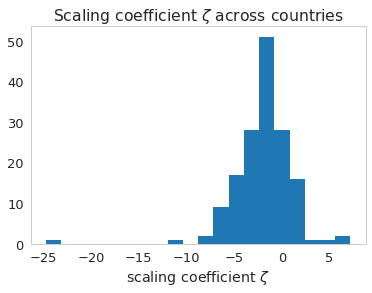

In [19]:
_ = plt.hist(stats_pop['coef'][~stats_pop['coef'].isnull()], bins=20)
plt.title("Scaling coefficient $\zeta$ across countries")
plt.xlabel("scaling coefficient $\zeta$")

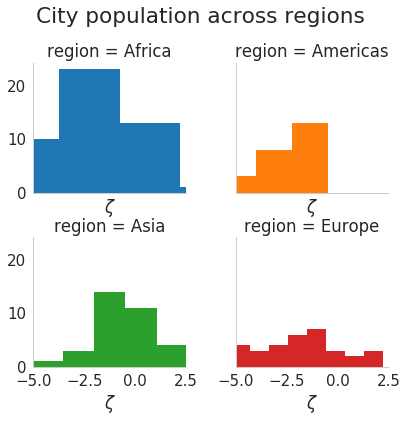

In [20]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

g = sns.FacetGrid(stats_pop[stats_pop['region']!='Oceania'],
                  col="region", hue="region", xlim=(-5,2.5), col_wrap=2)
g = g.map(plt.hist, "coef", bins=10)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("City population across regions \n\n")
for i in range(4):
    g.axes[i].set_xlabel("$\zeta$")

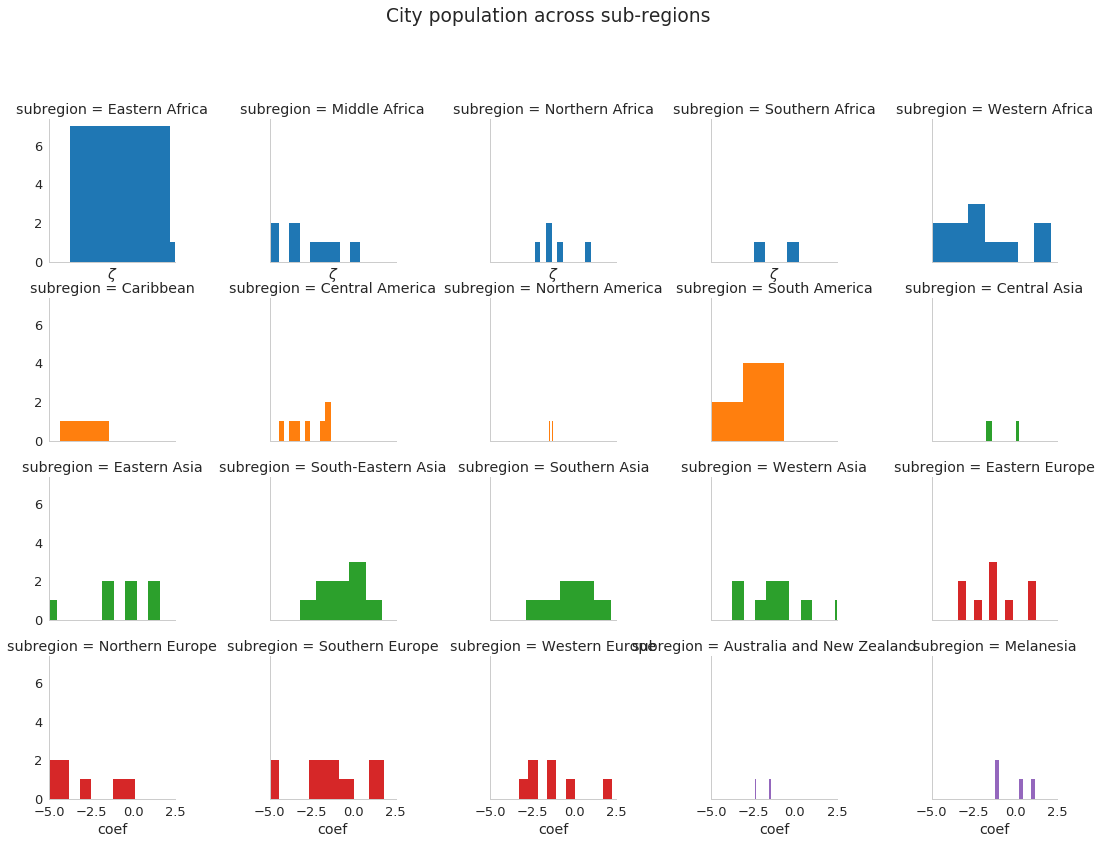

In [21]:
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1})

g = sns.FacetGrid(stats_pop[stats_pop['subregion']!='Polynesia'],
                  col="subregion", hue="region", xlim=(-5,2.5), col_wrap=5)
g = g.map(plt.hist, "coef", bins=10)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("City population across sub-regions \n\n")
for i in range(4):
    g.axes[i].set_xlabel("$\zeta$")

# Extract example cities

#### Functions to process images for display

In [ ]:
def basic_preprocess(img0, res, scale=True, preserve_sum=False, thresh=0):
    img = img0.copy()
    if img is None:
        return None
    img[img<thresh] = 0
    if preserve_sum:
        W, H = img.shape[:2]
        scale_w = W / float(res)
        scale_h = H / float(res)
        img = img * scale_w * scale_h
    img = resize(img.squeeze(), (res,res), preserve_range=True)#.astype(int)
    if scale:
        img = (img - img.min()) / (img.max() - img.min())
    return img

def overlay_mask(img, mask, ax, alpha=0.4):
    masked_data = np.ma.masked_where(mask, img)
    mask_countour = np.ma.masked_where(mask<0.5, img)
    # Overlay the two images
    ax.imshow(img, cmap=cm.GnBu)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)
    ax.imshow(mask_countour, cmap=cm.Reds, interpolation='none', alpha=alpha)
    
def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)


#### Plot some examples

In [ ]:
nimg = 4
nrow = 3

# smpl_df = cities_df_sel[cities_df_sel['Population']>2e6].sample(nimg).reset_index()

mycities = [("paris", "fra"), ("rio de janeiro", "bra"), 
            ("san francisco", "usa"), ("dhaka", "bgd")]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(10,6))
gs1 = gridspec.GridSpec(nrow, nimg)
gs1.update(wspace=0.0, hspace=0.05) # set the spacing between axes. 

for i, (cityname,countrycode) in enumerate(mycities):
    r = cities_gdf[(cities_gdf['city']==cityname) & (cities_gdf['countrycode']==countrycode)].iloc[0]
    lonlat, boundary = r['location'].centroid.xy, r['geometry']
    lon, lat = lonlat[0][0], lonlat[1][0]
    
    # extract population and compute total within city boundary
    imgPOP = popImgClient.extract_polygon_mask(boundary, w=100)
    imgPOP, bounds_mask = imgPOP[0], imgPOP[1]
    imgPOP[imgPOP<0] = 0
    city_pop = imgPOP[bounds_mask>0].sum()
    print cityname, city_pop
    imgPOP_disp = basic_preprocess(imgPOP, 128, log=True)
    bounds_mask = basic_preprocess(bounds_mask, 128)
    
    # built areas and nightlights
    imgSAR = sarImgClient.get_image_at_location((lat, lon), w=100)
    imgSAR_disp = basic_preprocess(imgSAR, 128)
    imgNLI = nliImgClient.get_image_at_location((lat, lon), w=100)
    imgNLI_disp = basic_preprocess(imgNLI, 128, log=True)
    
    # mark water areas with NaNs -- nothing can be built here
    imgWTR = wtrImgClient.get_image_at_location((lat, lon), w=100)
    water_mask = basic_preprocess(imgWTR, 128)

    imgPOP_disp[water_mask==0] = np.nan
    imgNLI_disp[water_mask==0] = np.nan
    imgSAR_disp[water_mask==0] = np.nan
    
    # plot built areas
    ax0 = plt.subplot(gs1[0,i]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(imgSAR_disp, bounds_mask>0, ax0); ax0.set_ylabel("built areas \n (SAR)") if i==0 else None
    # plot Nightlights
    ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
    overlay_mask(imgNLI_disp, bounds_mask>0, ax1); ax1.set_ylabel("nightlights \n (VIIRS)") if i==0 else None
    # plot population
    ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
    overlay_mask(imgPOP_disp, bounds_mask>0, ax2); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax0.set_title("%s,%s\n(pop %s)"%(cityname,countrycode[:2], format_pop(city_pop)))
    

# Prune cities to spatially well-separated set

In [ ]:
import geopy
from geopy import distance
from collections import OrderedDict
from sklearn.neighbors import KDTree, BallTree

from pysatml.utils.gis_utils import compute_geo_distance_km

point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())
    
cities_gdf_10k = cities_gdf[cities_gdf['population']>=1e5].copy()
cities_gdf_10k.sort_values("population", ascending=False, inplace=True)
cities_gdf_10k = cities_gdf_10k.reset_index().drop("index", 1)
cityloc_latlon = np.array(map(lambda x: (x.centroid.xy[1][0], x.centroid.xy[0][0]), 
    cities_gdf_10k['location'].values))
spatial_index = BallTree(cityloc_latlon, leaf_size=10, \
                         metric=compute_geo_distance_km)

# construct ordered dictionary of cities
cities_list = cities_gdf_10k.to_dict("records")
cities_list.sort(key=lambda x: x['population'])
cities_list = cities_list[::-1]
cities_dict = OrderedDict(zip([x['City'] for x in cities_list], cities_list))

In [ ]:
n_neighbors = 20   # number of nearest neighbors to query
d_threshold = 50   # radius in KM
size_thresh = 3

to_remove = set()
already_visited = set()
new_pop = {}

i = 0
while i < len(cities_dict):
    c0 = cities_dict.keys()[i]
    if c0 in to_remove:
        i += 1
        continue
    already_visited = already_visited.union(set([c0]))
    print i, '/', len(cities_dict), ":", c0
    clear_output(wait=True)
    r0 = cities_dict[c0]
    p = r0['location']
    loc0 = point2loc(p)[::-1]
    neighbors_dist, neighbors_indx = spatial_index.query(loc0, k=n_neighbors)
    neighbors_dist, neighbors_indx = neighbors_dist.squeeze(), neighbors_indx.squeeze()
    neighbors_close = neighbors_dist<d_threshold
    neighbors_indx = neighbors_indx[neighbors_close]
    neighbors_dist = neighbors_dist[neighbors_close]
    new_pop[c0] = r0['population']
    if len(neighbors_indx)>1:
        for n in neighbors_indx[1:]:
            r = cities_gdf_10k.iloc[n]
            c = r['City']
            if c not in already_visited and r0['population']>size_thresh*r['population']:
                to_remove = to_remove.union(set([c]))
                new_pop[c0] += r['population']
    i += 1
    
cities_gdf_sel = cities_gdf_10k[~cities_gdf_10k['City'].isin(to_remove)]
cities_gdf_sel['Adj. population'] = map(lambda c,p: new_pop[c] if c in new_pop else p,
                                  cities_gdf_sel['City'], cities_gdf_sel['population'])
cities_gdf_sel.reset_index(inplace=True)

print "Cities over 100k pop: %d; Pruned list: %d cities. "%(len(cities_gdf_10k), len(cities_gdf_sel))

In [ ]:
[v for c,v in cities_dict.iteritems() if 'contra costa, california' in c]

In [ ]:
[s for s in to_remove if 'san francisco' in s]

In [ ]:
cities_gdf_sel.to_csv(outPath + "/selected_urban_areas_100k.csv", index=False)
cities_gdf_sel.drop('location',1).to_file(driver = 'ESRI Shapefile', 
                                          filename=outPath + "boundaries/selected_urban_areas_100k.shp")

# cities_df_sel = gpd.GeoDataFrame(pd.read_csv(outPath + "/selected_urban_areas.csv"))
# cities_df_sel['geometry'] = cities_df_sel['geometry'].apply(lambda x: loads(x))

In [ ]:
cities_gdf_sel[cities_gdf_sel.city.str.contains("boston")]

In [ ]:
city_locations_sel = gpd.GeoSeries(cities_gdf_sel['location'])
city_locations_sel.plot(figsize=(8,6), cmap='Greys')
plt.title("Large Metropolitan Areas", fontsize=16)
plt.ylabel("latitude", fontsize=16)
plt.xlabel("longitude", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [ ]:
dist_25 = cities_gdf_10k['size'].value_counts() / float(len(cities_gdf_10k))
dist_03 = cities_gdf_sel['size'].value_counts() / float(len(cities_gdf_sel))
scale_df = pd.concat([dist_25, dist_03], axis=1)
scale_df.columns = ["30k cities", "7.5k cities"]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
scale_df.plot(kind="bar")
plt.title("City scale distribution")
plt.ylabel("pct. total")

# Extract  samples: 
* training: all cities > 10k population
* test: filtered cities (by population & location)

In [ ]:
kmScale = 100 # window of 100km width around center
res = 128
thresh_pop = 0 #int(1.5 * 100 * 9.0/16)
thresh_lum = 0

# training samples
df = cities_gdf[cities_gdf.population>10000]

cur_dir = outPath + "spatial-maps/raw"
if not os.path.exists(cur_dir):
    os.makedirs(cur_dir)

from skimage.io import imsave

for i,(idx,r) in enumerate(df.iterrows()):
    clear_output(wait=True)
    print "city %d/%d" % (i, len(df))

    lonlat, boundary = r['location'], r['geometry']
    imgLat, imgLon = point2loc(lonlat)[::-1]
    city, province, country = r['city'].replace(" ","-"), r['province'].replace(" ","-"), r['country'].replace(" ","-")
    popNum, popClass = int(r['population']), r['size'].replace(" ","-")

    # extract population and compute total within city boundary
#     try:
#         imgPOP = popImgClient.extract_polygon_mask(boundary, w=kmScale)
#     except:
#         imgPOP = popImgClient.extract_polygon_mask(boundary.buffer(2).buffer(-2), w=kmScale)
#     imgPOP, bounds_mask = imgPOP[0], imgPOP[1]
#     imgPOP = np.ceil(basic_preprocess(imgPOP, res, scale=False, preserve_sum=True, thresh=thresh_pop))
#     bounds_mask = basic_preprocess(bounds_mask, res)

#     imgSAR = sarImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
#     imgSAR = basic_preprocess(imgSAR, res, preserve_sum=True)
    
    imgNLI = nliImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    imgNLI = basic_preprocess(imgNLI, res, scale=False, thresh=thresh_lum)
    
#     imgWTR = wtrImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
#     imgWTR = basic_preprocess(imgWTR, res, preserve_sum=False)
   
#     if imgSAR is None or imgNLI is None or imgPOP is None or imgWTR is None:
#         continue
                       
#     # save images to files
#     filename = "%s/SAR_%s_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, province, city, popClass, popNum, imgLat, imgLon) 
#     imsave(filename, imgSAR)
    filename = "%s/NLI_%s_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, province, city, popClass, popNum, imgLat, imgLon) 
    imsave(filename, imgNLI)
#     filename = "%s/POP_%s_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, province, city, popClass, popNum, imgLat, imgLon) 
#     imsave(filename, imgPOP)
#     filename = "%s/WTR_%s_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, province, city, popClass, popNum, imgLat, imgLon) 
#     imsave(filename, imgWTR)
#     filename = "%s/BND_%s_%s_%s_%s_%d_%2.4f_%2.4f.tif"%(cur_dir, country, province, city, popClass, popNum, imgLat, imgLon) 
#     imsave(filename, bounds_mask)
